In [1]:
!pip install -q pycountry

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 60.3 MB/s eta 0:00:00:00:010:01


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import geopandas as gpd
import pickle
import scipy.stats as stats
import pycountry
from datetime import datetime, timedelta
from tqdm import tqdm
from scipy import stats
import scipy
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tools import add_constant
from collections import defaultdict, Counter
from itertools import chain, combinations
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import PercentFormatter

In [3]:
import matplotlib
matplotlib.rcParams['font.size'] = 30

### Regional Data & Statistics

In [4]:
regions = {
    'Middle East': ['AE', 'BH', 'IQ', 'IL', 'JO', 'KW', 'LB', 'OM', 'QA', 'SA', 'YE'],
    'North Africa': ['DZ', 'EG', 'LY', 'MA', 'TN'],
    'North America': ['CA', 'US'],
    'South Asia': ['BD', 'IN', 'LK', 'NP', 'PK'],
    'Caribbean': ['JM', 'PR', 'DO'],
    'Southeast Asia': ['ID', 'KH', 'LA', 'MY', 'PH', 'SG', 'TH', 'VN'],
    'East Asia': ['HK', 'JP', 'KR', 'MN', 'TW'],
    'Europe': ['AL', 'AT', 'BA', 'BE', 'BG', 'CH', 'CY', 'CZ', 'DE', 'DK', 'EE', 'ES', 
               'FI', 'FR', 'GB', 'GR', 'HR', 'HU', 'IE', 'IS', 'IT', 'LI', 'LT', 'LU', 
               'LV', 'MD', 'ME', 'MK', 'MT', 'NL', 'NO', 'PL', 'PT', 'RO', 'RS', 'RU', 
               'SE', 'SI', 'SK', 'UA'],
    'Latin America': ['AR', 'BO', 'BR', 'CL', 'CO', 'CR', 'DO', 'EC', 'GT', 'HN', 'MX', 
                     'NI', 'PA', 'PE', 'PR', 'PY', 'SV', 'UY', 'VE'],
    'Sub-Saharan Africa': ['GH', 'KE', 'NG', 'SN', 'TZ', 'UG', 'ZA', 'ZW'],
    'Oceania': ['AU', 'NZ', 'PG'],
    'Central Asia': ['AM', 'AZ', 'GE', 'KZ'],
}

hdi_index_by_country = {
    'US': 0.927,  # United States
    #'BY': 0.801,  # Belarus
    'RS': 0.805,  # Serbia
    'LK': 0.780,  # Sri Lanka
    'DE': 0.950,  # Germany
    'KW': 0.847,  # Kuwait
    'BH': 0.888,  # Bahrain
    'MY': 0.807,  # Malaysia
    'PE': 0.762,  # Peru
    'KH': 0.600,  # Cambodia
    'ZW': 0.550,  # Zimbabwe (updated)
    'DO': 0.766,  # Dominican Republic
    'LU': 0.927,  # Luxembourg
    'RO': 0.827,  # Romania
    'EE': 0.899,  # Estonia
    'AU': 0.946,  # Australia
    'CA': 0.935,  # Canada
    'PK': 0.540,  # Pakistan (updated)
    'QA': 0.875,  # Qatar
    'BD': 0.670,  # Bangladesh
    'TH': 0.803,  # Thailand
    'EG': 0.728,  # Egypt
    'AL': 0.789,  # Albania
    'MA': 0.698,  # Morocco
    'UA': 0.734,  # Ukraine
    'TN': 0.732,  # Tunisia
    'FR': 0.910,  # France
    'DZ': 0.745,  # Algeria
    'LA': 0.620,  # Lao PDR
    'AM': 0.786,  # Armenia
    'YE': 0.424,  # Yemen (updated)
    'AZ': 0.760,  # Azerbaijan
    'ZA': 0.717,  # South Africa
    'UG': 0.550,  # Uganda (updated)
    'HN': 0.624,  # Honduras
    'CY': 0.907,  # Cyprus
    'PY': 0.731,  # Paraguay
    'BO': 0.698,  # Bolivia
    'KZ': 0.802,  # Kazakhstan
    'MD': 0.763,  # Moldova
    'LY': 0.746,  # Libya
    'VE': 0.699,  # Venezuela
    'MK': 0.765,  # North Macedonia
    'IS': 0.959,  # Iceland
    'ES': 0.911,  # Spain
    'CH': 0.967,  # Switzerland
    'ME': 0.844,  # Montenegro
    'JP': 0.920,  # Japan
    'KR': 0.929,  # Korea, Republic of
    'CZ': 0.895,  # Czech Republic
    'PR': None,   # Puerto Rico (no data provided)
    'HR': 0.878,  # Croatia
    'GT': 0.629,  # Guatemala
    'DK': 0.952,  # Denmark
    'SN': 0.517,  # Senegal (updated)
    'IL': 0.915,  # Israel
    'AR': 0.849,  # Argentina
    'SK': 0.855,  # Slovakia
    'HK': 0.956,  # Hong Kong
    'GH': 0.602,  # Ghana
    'ID': 0.713,  # Indonesia
    'HU': 0.851,  # Hungary
    'NP': 0.601,  # Nepal
    'GR': 0.893,  # Greece
    'MX': 0.781,  # Mexico
    'MN': 0.741,  # Mongolia
    'RU': 0.821,  # Russian Federation
    'LB': 0.723,  # Lebanon
    'BG': 0.799,  # Bulgaria
    'TW': 0.916,   # Taiwan (no data provided)
    'IE': 0.950,  # Ireland
    'PT': 0.874,  # Portugal
    'PA': 0.820,  # Panama
    'JO': 0.736,  # Jordan
    'NI': 0.669,  # Nicaragua
    'PH': 0.710,  # Philippines
    'NL': 0.946,  # Netherlands
    'PL': 0.881,  # Poland
    'LV': 0.879,  # Latvia
    'SG': 0.949,  # Singapore
    'IQ': 0.673,  # Iraq
    'EC': 0.765,  # Ecuador
    'SV': 0.674,  # El Salvador
    'CL': 0.860,  # Chile
    'LI': 0.942,  # Liechtenstein
    'BR': 0.760,  # Brazil
    'MT': 0.915,  # Malta
    'JM': 0.706,  # Jamaica
    'SE': 0.952,  # Sweden
    'TZ': 0.532,  # Tanzania (updated)
    #'TR': 0.855,  # Turkey
    'CR': 0.806,  # Costa Rica
    'FI': 0.942,  # Finland
    'GE': 0.814,  # Georgia
    'SA': 0.875,  # Saudi Arabia
    'PG': 0.568,  # Papua New Guinea (updated)
    'IN': 0.644,  # India
    'LT': 0.879,  # Lithuania
    'VN': 0.726,  # Vietnam
    'IT': 0.906,  # Italy
    'NZ': 0.939,  # New Zealand
    'AT': 0.926,  # Austria
    'AE': 0.937,  # United Arab Emirates
    'UY': 0.830,  # Uruguay
    'CO': 0.758,  # Colombia
    'KE': 0.601,  # Kenya
    'SI': 0.926,  # Slovenia
    'NG': 0.548,  # Nigeria (updated)
    'GB': 0.940,  # United Kingdom
    'BE': 0.942,  # Belgium
    'BA': 0.779,  # Bosnia and Herzegovina
    'OM': 0.819,  # Oman
    'NO': 0.966   # Norway
}

country_languages_official = {
    'AL': ['sq'], 'AT': ['de-AT'], 'BA': ['bs', 'hr', 'sr-Cyrl', 'sr-Latn'], 'BE': ['nl-BE', 'fr-BE', 'de-BE'],
    'BG': ['bg'], 'CY': ['el', 'tr'], 'CZ': ['cs'], 'DE': ['de-DE'], 'DK': ['da'], 'EE': ['et'], 'ES': ['es-ES'],
    'FI': ['fi', 'sv'], 'FR': ['fr-FR'], 'GB': ['en-GB'], 'GR': ['el'], 'HR': ['hr'], 'HU': ['hu'], 'IE': ['en-IE', 'ga'],
    'IS': ['is'], 'IT': ['it'], 'LT': ['lt'], 'LU': ['lb', 'fr-LU', 'de-LU'], 'LV': ['lv'], 'ME': ['sr-Cyrl', 'sr-Latn'],
    'MK': ['mk'], 'NL': ['nl-NL'], 'PL': ['pl'], 'PT': ['pt-PT'], 'RO': ['ro'], 'RS': ['sr-Cyrl', 'sr-Latn'], 'RU': ['ru'],
    'SE': ['sv'], 'SI': ['sl'], 'SK': ['sk'], 'UA': ['uk']
}

country_languages_widely_spoken = {
    'AL': ['sq', 'it'], 'AT': ['de-AT', 'en-GB'], 'BA': ['bs', 'hr', 'sr-Cyrl', 'sr-Latn'], 'BE': ['nl-BE', 'fr-BE', 'de-BE', 'en-GB'],
    'BG': ['bg', 'ru'], 'CY': ['el', 'tr', 'en-GB'], 'CZ': ['cs', 'de-DE', 'en-GB'], 'DE': ['de-DE', 'en-GB', 'tr'], 'DK': ['da', 'en-GB'],
    'EE': ['et', 'ru'], 'ES': ['es-ES', 'en-GB', 'ca'], 'FI': ['fi', 'sv', 'en-GB'], 'FR': ['fr-FR', 'en-GB'], 'GB': ['en-GB'],
    'GR': ['el', 'en-GB'], 'HR': ['hr', 'en-GB'], 'HU': ['hu', 'en-GB'], 'IE': ['en-IE', 'ga'], 'IS': ['is', 'en-GB'],
    'IT': ['it', 'en-GB'], 'LT': ['lt', 'ru'], 'LU': ['lb', 'fr-LU', 'de-LU', 'en-GB'], 'LV': ['lv', 'ru'], 'ME': ['sr-Cyrl', 'sr-Latn', 'ru'],
    'MK': ['mk', 'bg', 'sr-Cyrl', 'sr-Latn'], 'NL': ['nl-NL', 'en-GB'], 'PL': ['pl', 'de-DE', 'en-GB'], 'PT': ['pt-PT', 'en-GB'],
    'RO': ['ro', 'en-GB'], 'RS': ['sr-Cyrl', 'sr-Latn', 'ru'], 'RU': ['ru'], 'SE': ['sv', 'en-GB'], 'SI': ['sl', 'en-GB'], 'SK': ['sk', 'hu', 'en-GB'],
    'UA': ['uk', 'ru']
}

catid2str = {
    2 : 'Autos & Vehicles',
    1 :  'Film & Animation',
    10 : 'Music',
    15 : 'Pets & Animals',
    17 : 'Sports',
    18 : 'Short Movies',
    19 : 'Travel & Events',
    20 : 'Gaming',
    21 : 'Videoblogging',
    22 : 'People & Blogs',
    23 : 'Comedy',
    24 : 'Entertainment',
    25 : 'News & Politics',
    26 : 'Howto & Style',
    27 : 'Education',
    28 : 'Science & Technology',
    29 : 'Nonprofits & Activism',
    30 : 'Movies',
    31 : 'Anime/Animation',
    32 : 'Action/Adventure',
    33 : 'Classics',
    34 : 'Comedy',
    35 : 'Documentary',
    36 : 'Drama',
    37 : 'Family',
    38 : 'Foreign',
    39 : 'Horror',
    40 : 'Sci-Fi/Fantasy',
    41 : 'Thriller',
    42 : 'Shorts',
    43 : 'Shows',
    44 : 'Trailers'
}
country_to_iso_regions = {
    'Europe' : {
        'AL': 'ALB',  # Albania
        'AT': 'AUT',  # Austria
        'BA': 'BIH',  # Bosnia and Herzegovina
        'BE': 'BEL',  # Belgium
        'BG': 'BGR',  # Bulgaria
        'CH': 'CHE',  # Switzerland
        'CY': 'CYP',  # Cyprus
        'CZ': 'CZE',  # Czech Republic
        'DE': 'DEU',  # Germany
        'DK': 'DNK',  # Denmark
        'EE': 'EST',  # Estonia
        'ES': 'ESP',  # Spain
        'FI': 'FIN',  # Finland
        'FR': 'FRA',  # France
        'GB': 'GBR',  # United Kingdom
        'GR': 'GRC',  # Greece
        'HR': 'HRV',  # Croatia
        'HU': 'HUN',  # Hungary
        'IE': 'IRL',  # Ireland
        'IS': 'ISL',  # Iceland
        'IT': 'ITA',  # Italy
        'LI': 'LIE',  # Liechtenstein
        'LT': 'LTU',  # Lithuania
        'LU': 'LUX',  # Luxembourg
        'LV': 'LVA',  # Latvia
        'MD': 'MDA',  # Moldova
        'ME': 'MNE',  # Montenegro
        'MK': 'MKD',  # North Macedonia
        'MT': 'MLT',  # Malta
        'NL': 'NLD',  # Netherlands
        'NO': 'NOR',  # Norway
        'PL': 'POL',  # Poland
        'PT': 'PRT',  # Portugal
        'RO': 'ROU',  # Romania
        'RS': 'SRB',  # Serbia
        'RU': 'RUS',  # Russia
        'SE': 'SWE',  # Sweden
        'SI': 'SVN',  # Slovenia
        'SK': 'SVK',  # Slovakia
        'UA': 'UKR'   # Ukraine
    },
    'Middle East' : {
        'AE': 'ARE',  # United Arab Emirates
        'BH': 'BHR',  # Bahrain
        'IQ': 'IRQ',  # Iraq
        'IL': 'ISR',  # Israel
        'JO': 'JOR',  # Jordan
        'KW': 'KWT',  # Kuwait
        'LB': 'LBN',  # Lebanon
        'OM': 'OMN',  # Oman
        'QA': 'QAT',  # Qatar
        'SA': 'SAU',  # Saudi Arabia
        'YE': 'YEM'   # Yemen
    },
    'North Africa': {
        'DZ': 'DZA',  # Algeria
        'EG': 'EGY',  # Egypt
        'LY': 'LBY',  # Libya
        'MA': 'MAR',  # Morocco
        'TN': 'TUN'   # Tunisia
    },
    'North America' : {
        'CA': 'CAN',  # Canada
        'US': 'USA'   # United States of America
    },
    'South Asia': {
    'BD': 'BGD',  # Bangladesh
    'IN': 'IND',  # India
    'LK': 'LKA',  # Sri Lanka
    'NP': 'NPL',  # Nepal
    'PK': 'PAK'   # Pakistan
},
'Caribbean':{
    'JM': 'JAM',  # Jamaica
    'PR': 'PRI',  # Puerto Rico
    'DO': 'DOM'   # Dominican Republic
},
'Southeast Asia': {
    'ID': 'IDN',  # Indonesia
    'KH': 'KHM',  # Cambodia
    'LA': 'LAO',  # Laos
    'MY': 'MYS',  # Malaysia
    'PH': 'PHL',  # Philippines
    'SG': 'SGP',  # Singapore
    'TH': 'THA',  # Thailand
    'VN': 'VNM'   # Vietnam
},
'East Asia': {
    'HK': 'HKG',  # Hong Kong
    'JP': 'JPN',  # Japan
    'KR': 'KOR',  # South Korea
    'MN': 'MNG',  # Mongolia
    'TW': 'TWN'   # Taiwan
},
'Latin America':{
    'AR': 'ARG',  # Argentina
    'BO': 'BOL',  # Bolivia
    'BR': 'BRA',  # Brazil
    'CL': 'CHL',  # Chile
    'CO': 'COL',  # Colombia
    'CR': 'CRI',  # Costa Rica
    'DO': 'DOM',  # Dominican Republic
    'EC': 'ECU',  # Ecuador
    'GT': 'GTM',  # Guatemala
    'HN': 'HND',  # Honduras
    'MX': 'MEX',  # Mexico
    'NI': 'NIC',  # Nicaragua
    'PA': 'PAN',  # Panama
    'PE': 'PER',  # Peru
    'PR': 'PRI',  # Puerto Rico
    'PY': 'PRY',  # Paraguay
    'SV': 'SLV',  # El Salvador
    'UY': 'URY',  # Uruguay
    'VE': 'VEN'   # Venezuela
},
'Sub-Saharan Africa':{
    'GH': 'GHA',  # Ghana
    'KE': 'KEN',  # Kenya
    'NG': 'NGA',  # Nigeria
    'SN': 'SEN',  # Senegal
    'TZ': 'TZA',  # Tanzania
    'UG': 'UGA',  # Uganda
    'ZA': 'ZAF',  # South Africa
    'ZW': 'ZWE'   # Zimbabwe
},
'Oceania':{
    'AU': 'AUS',  # Australia
    'NZ': 'NZL',  # New Zealand
    'PG': 'PNG'   # Papua New Guinea
},
'Central Asia': {
    'AM': 'ARM',  # Armenia
    'AZ': 'AZE',  # Azerbaijan
    'GE': 'GEO',  # Georgia
    'KZ': 'KAZ'   # Kazakhstan
}    
}

### Data Loading

In [5]:
def filter_dataframe(df):
    return df.query("view_count < 0.5e9 and days_after_pub_to_first_trend >= 0").reset_index(drop=True)

def load_country_data(country_code):
    """Load data for a specific country and return emoji usage statistics"""
    try:
        df = pd.read_csv(f"../dat/dataset_with_features_{country_code}.csv")
        df = filter_dataframe(df)
        return df
    except FileNotFoundError:
        print(f"No data found for {country_code}")
        return None
full_dataset_by_country = {}
for region in tqdm(regions):
    for country_code in regions[region]:
        df = load_country_data(country_code)
        full_dataset_by_country[country_code] = (df.iloc[df['video_id'].drop_duplicates().index]).reset_index(drop=True)

100%|██████████| 12/12 [01:37<00:00,  8.11s/it]


# 3. Explore country trending videos language

Goal:

We want to discover for countries proportion of videos in trending in native language. This time we will also deduplicate videos in each country's trending for year and make sure that we have only one video per channel. So we analyze country-specific videos and we can assume that they are independent across countries.

Proportion of non-oficial languages would potentionaly show us cultural diversity in country as more videos in non-oficial language may demonstrate language usage / literacy among population.

For analysis we take european countries with nore than 200 videos

In [27]:
eu_coutries_to_take_here = ['AL', 'AT', 'BA', 'BE', 'BG', 'CH', 'CY', 'CZ', 'DE', 'DK', 'EE', 'ES', 
               'FI', 'FR', 'GB', 'GR', 'HR', 'HU', 'IE', 'IS', 'IT', 'LI', 'LT', 'LU', 
               'LV', 'MD', 'ME', 'MK', 'MT', 'NL', 'NO', 'PL', 'PT', 'RO', 'RS', 'RU', 
               'SE', 'SI', 'SK', 'UA']
country_languages = {
    'AL': ['sq'], 'AT': ['de'], 'BA': ['bs', 'hr', 'sr'], 'BE': ['nl', 'fr', 'de'], 'BG': ['bg'], 'CH': ['de', 'fr', 'it', 'rm'],
    'CY': ['el', 'tr'], 'CZ': ['cs'], 'DE': ['de'], 'DK': ['da'], 'EE': ['et'], 'ES': ['es', 'ca', 'gl', 'eu'],
    'FI': ['fi', 'sv'], 'FR': ['fr'], 'GB': ['en'], 'GR': ['el'], 'HR': ['hr'], 'HU': ['hu'], 'IE': ['en', 'ga'],
    'IS': ['is'], 'IT': ['it'], 'LI': ['de'], 'LT': ['lt'], 'LU': ['lb', 'fr', 'de'], 'LV': ['lv'],
    'MD': ['ro'], 'ME': ['sr'], 'MK': ['mk'], 'MT': ['mt', 'en'], 'NL': ['nl'], 'NO': ['no'], 'PL': ['pl'],
    'PT': ['pt'], 'RO': ['ro'], 'RS': ['sr'], 'RU': ['ru'], 'SE': ['sv'], 'SI': ['sl'], 'SK': ['sk'], 'UA': ['uk']
}
country_languages_official = {
    'AL': ['sq'], 'AT': ['de-AT'], 'BA': ['bs', 'hr', 'sr-Cyrl', 'sr-Latn'], 'BE': ['nl-BE', 'fr-BE', 'de-BE'],
    'BG': ['bg'], 'CY': ['el', 'tr'], 'CZ': ['cs'], 'DE': ['de-DE'], 'DK': ['da'], 'EE': ['et'], 'ES': ['es-ES'],
    'FI': ['fi', 'sv'], 'FR': ['fr-FR'], 'GB': ['en-GB'], 'GR': ['el'], 'HR': ['hr'], 'HU': ['hu'], 'IE': ['en-IE', 'ga'],
    'IS': ['is'], 'IT': ['it'], 'LT': ['lt'], 'LU': ['lb', 'fr-LU', 'de-LU'], 'LV': ['lv'], 'ME': ['sr-Cyrl', 'sr-Latn'],
    'MK': ['mk'], 'NL': ['nl-NL'], 'PL': ['pl'], 'PT': ['pt-PT'], 'RO': ['ro'], 'RS': ['sr-Cyrl', 'sr-Latn'], 'RU': ['ru'],
    'SE': ['sv'], 'SI': ['sl'], 'SK': ['sk'], 'UA': ['uk']
}

In [28]:
def prepare_language_analysis_data( dataset: dict, countries: list, min_samples: int = 200 ) -> dict[str, pd.Series]:
    """
    Prepares data for selected EU countries.
    Specificaly, we filter videos as before to make sure independence.
    
    Args:
        dataset: Dictionary of DataFrames by country code
        eu_countries: List of EU country codes to analyze
        min_samples: Minimum number of samples required per country
        
    Returns:
        Dictionary mapping country codes to language distributions in it's specific videos
    """
    video_counter = defaultdict(int)
    for country_df in dataset.values():
        unique_videos = country_df['video_id'].unique()
        for video_id in unique_videos:
            video_counter[video_id] += 1
    country_specific_videos = {vid for vid, count in video_counter.items() if count == 1}
    
    country_unique_vids = {
        country: set(df['video_id']).intersection(country_specific_videos)
        for country, df in dataset.items()
    }
    
    result = {}
    for country in countries:
        if country not in dataset:
            print("Skip")
            continue
        langs = dataset[country].loc[dataset[country]['video_id'].isin(country_unique_vids.get(country, set())),'langauge'].values 
        if len(langs) >= min_samples:
            result[country] = langs
            
    return result

In [29]:
country2languageusage = prepare_language_analysis_data(full_dataset_by_country, full_dataset_by_country.keys(), min_samples=5)

In [30]:
native_english_countries = {'CA', 'US', 'JM', 'PR', 'IN', 'PK', 'PH', 'SG', 'HK', 'GB', 'IE', 'MT',
                'GH', 'KE', 'NG', 'TZ', 'UG', 'ZA', 'ZW', 'AU', 'NZ', 'PG'}

In [31]:
def visualize_pvalues(pvalues, figsize=(18, 16), cmap='viridis_r', alpha=0.05):
    regions = sorted({r for pair in pvalues.keys() for r in pair})
    df = pd.DataFrame(np.nan, index=regions, columns=regions)
    for (r1, r2), pval in pvalues.items():
        df.loc[r1, r2] = pval
        
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(
        df,
        cmap=cmap,
        annot=False,
        linewidths=0.3,
        linecolor='white',
        cbar_kws={
            'label': f'p-value (α={alpha})',
            'format': '%.2f',
            'boundaries': [0, alpha, 1]
        },
        vmin=0,
        vmax=1,
        ax=ax
    )
    
    n = len(regions)
    for i in range(n):
        for j in range(n):
            if i <= j: 
                continue
            p_val = df.iloc[i, j]
            if np.isnan(p_val):
                continue
            
            # Highlight p < alpha with gold rectangle
            if p_val < alpha:
                ax.add_patch(
                    plt.Rectangle(
                        (j, i), 1, 1,
                        fill=False,
                        edgecolor='gold',
                        lw=1.5,
                        clip_on=False))
            
            # Highlight p > 1-alpha with red dashed rectangle
            if p_val > (1 - alpha):
                ax.add_patch(
                    plt.Rectangle(
                        (j, i), 1, 1,
                        fill=False,
                        edgecolor='red',
                        linestyle='--',
                        lw=1.5,
                        clip_on=False))
    
    plt.tight_layout()
    return fig, ax

In [32]:
country2region = {c: reg for reg, countries in regions.items() for c in countries}
def is_english(lang_code):
    """Check if language code indicates English usage."""
    if not isinstance(lang_code, str) or lang_code.lower() == 'nan':
        return False
    return lang_code.startswith('en')

non_native_regions = defaultdict(list)
for c in country2languageusage:
    if c not in native_english_countries:
        non_native_regions[country2region[c]].append(c)

def get_english_usage(data, region):
    """Calculate English usage statistics for a region."""
    english_usage = []
    for country in non_native_regions[region]:
        lang_data = data[country].astype(str)
        english_usage.extend(is_english(lang) for lang in lang_data)
    
    if not english_usage:
        return 0, 0, 0.0
    total = len(english_usage)
    count = sum(english_usage)
    return count, total, count / total

def get_mean_eng_ratio(region, data):
    _, _, ratio = get_english_usage(data, region)
    return ratio

def get_indicators_for_region(region, data):
    count, total, _ = get_english_usage(data, region)
    return count, total

In [33]:
def calculate_region_pvalues(regions_list, data_source):
    """Calculate p-values for region comparisons using proportion z-test."""
    pvalues = {}
    
    precomputed = {
        region: get_indicators_for_region(region, data_source)
        for region in regions_list
    }
    
    for region_a, region_b in combinations(regions_list, 2):
        count_a, nobs_a = precomputed[region_a]
        count_b, nobs_b = precomputed[region_b]

        _, pvalue = proportions_ztest(
            [count_a, count_b],
            [nobs_a, nobs_b],
            alternative='smaller',
            prop_var=False
        )

        _, pvalue_opposite = proportions_ztest(
            [count_b, count_a],
            [nobs_b, nobs_a],
            alternative='smaller',
            prop_var=False
        )
        
        pvalues[(region_a, region_b)] = pvalue
        pvalues[(region_b, region_a)] = pvalue_opposite
    
    return pvalues

regions_to_compare = [
    'Middle East', 'North Africa', 'South Asia', 'Latin America',
    'Southeast Asia', 'East Asia', 'Europe', 'Sub-Saharan Africa', 'Central Asia'
]

pvalue_per_region_englishmaster = calculate_region_pvalues(
    regions_to_compare, 
    country2languageusage
)

This part of the process refines our statistical comparisons to ensure that any differences we observe between regions are truly significant, not just random chance. It takes the initial results from comparing language usage and adjusts them to account for the fact that we're making many comparisons at once.

In [34]:
# Correct P-values for multiple hypothesis
pvalues_initial = []
for country_pair in pvalue_per_region_englishmaster:
    pvalues_initial.append(pvalue_per_region_englishmaster[country_pair])
pvalues_corrected = scipy.stats.false_discovery_control(pvalues_initial, method='by')
for idx, country_pair in enumerate(pvalue_per_region_englishmaster):
    pvalue_per_region_englishmaster[country_pair] = pvalues_corrected[idx]

We are unable to include these results in our report due to the four-page limit.

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


(<Figure size 1800x1600 with 2 Axes>, <Axes: >)

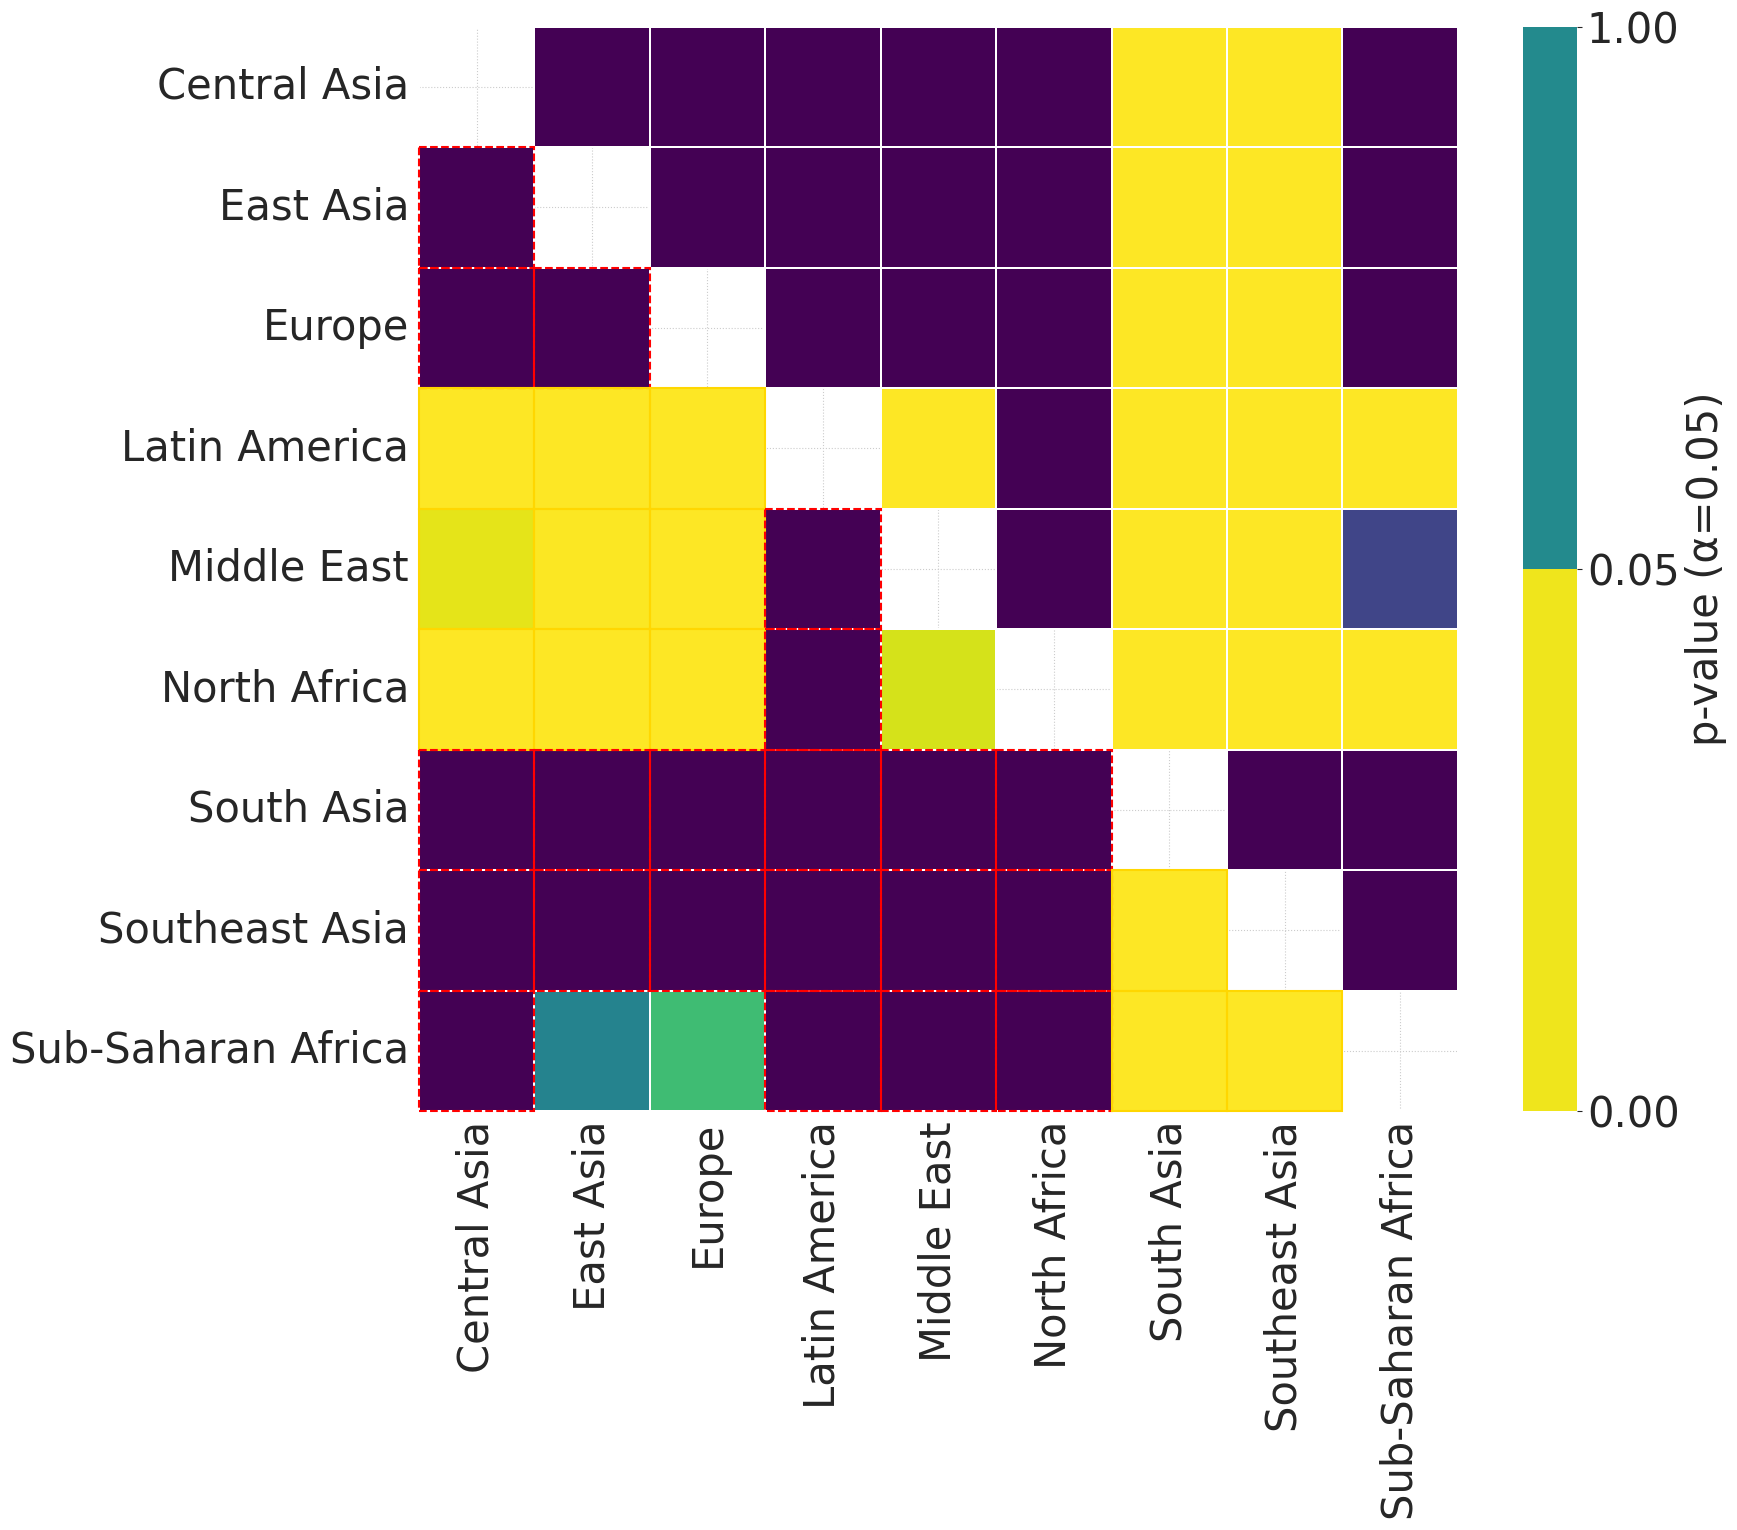

In [35]:
visualize_pvalues(pvalue_per_region_englishmaster)